In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.interpolate as interp
import scipy.optimize as opt
from scipy import stats
import healpy as hp
import os

In [6]:
plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size'   : 20})
plt.rc_context({'axes.autolimit_mode': 'round_numbers'})

# Load files

In [23]:
base_dir10 = '/Users/kristen/Documents/GitHub/CIB-deproj/cib_deproj_040125/planck1p0_highz_decorr_alpha10_bin200'
base_dir1 = '/Users/kristen/Documents/GitHub/CIB-deproj/cib_deproj_040125/planck1p0_highz_decorr_alpha1_bin200'
base_dir0p1 = '/Users/kristen/Documents/GitHub/CIB-deproj/cib_deproj_040125/planck1p0_highz_decorr_alpha0p1_bin200'

chi2_alpha10 = pickle.load(open(f'{base_dir10}/pickle_files/chi2_inflated_arr.p', 'rb')) #(Nbins, Nbetas)
chi2_alpha1 = pickle.load(open(f'{base_dir1}/pickle_files/chi2_inflated_arr.p', 'rb')) #(Nbins, Nbetas)
chi2_alpha0p1 = pickle.load(open(f'{base_dir0p1}/pickle_files/chi2_inflated_arr.p', 'rb')) #(Nbins, Nbetas)
chi2_true = pickle.load(open(f'{base_dir0p1}/pickle_files/chi2_true_arr.p', 'rb')) #(Nbins, Nbetas)

# each array below has contents [means_true, uppers_true, lowers_true, means_infl, uppers_infl, lowers_infl]
beta_alpha10 = pickle.load(open(f'{base_dir10}/pickle_files/beta_points_per_ell.p', 'rb')) 
beta_alpha1 = pickle.load(open(f'{base_dir1}/pickle_files/beta_points_per_ell.p', 'rb')) 
beta_alpha0p1 = pickle.load(open(f'{base_dir0p1}/pickle_files/beta_points_per_ell.p', 'rb')) 

# directory to save plots
save_dir = '/Users/kristen/Documents/GitHub/CIB-deproj/cib_deproj_040125/paper_plots'
os.makedirs(save_dir, exist_ok=True)
save = True # whether to save plots

# Set parameters to match runs

In [8]:
beta_arr =  [
  0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 
  0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 
  1.5, 1.5125, 1.525, 1.5375, 1.55, 1.5625, 1.575, 1.5875, 1.6, 1.6125, 1.625, 1.6375, 
  1.65, 1.6625, 1.675, 1.6875, 1.7, 1.7125, 1.725, 1.7375, 1.75, 1.7625, 1.775, 1.7875, 
  1.8, 1.8125, 1.825, 1.8375, 1.85, 1.8625, 1.875, 1.8875, 1.9, 1.95, 2.0, 2.05, 2.1, 
  2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 
  2.9, 2.95
]

ellmin, ellmax = 2, 2000
ells_per_bin = 200
nside = 1024


In [9]:
beta_arr = np.array(beta_arr)
ells = np.arange(ellmax+1)
Nbins = int(np.round((ellmax-ellmin+1)/ells_per_bin))
res = stats.binned_statistic(ells[ellmin:], ells[ellmin:], statistic='mean', bins=Nbins)
mean_ells = (res[1][:-1]+res[1][1:])/2


# $\chi^2$ vs. $\beta$ Plots

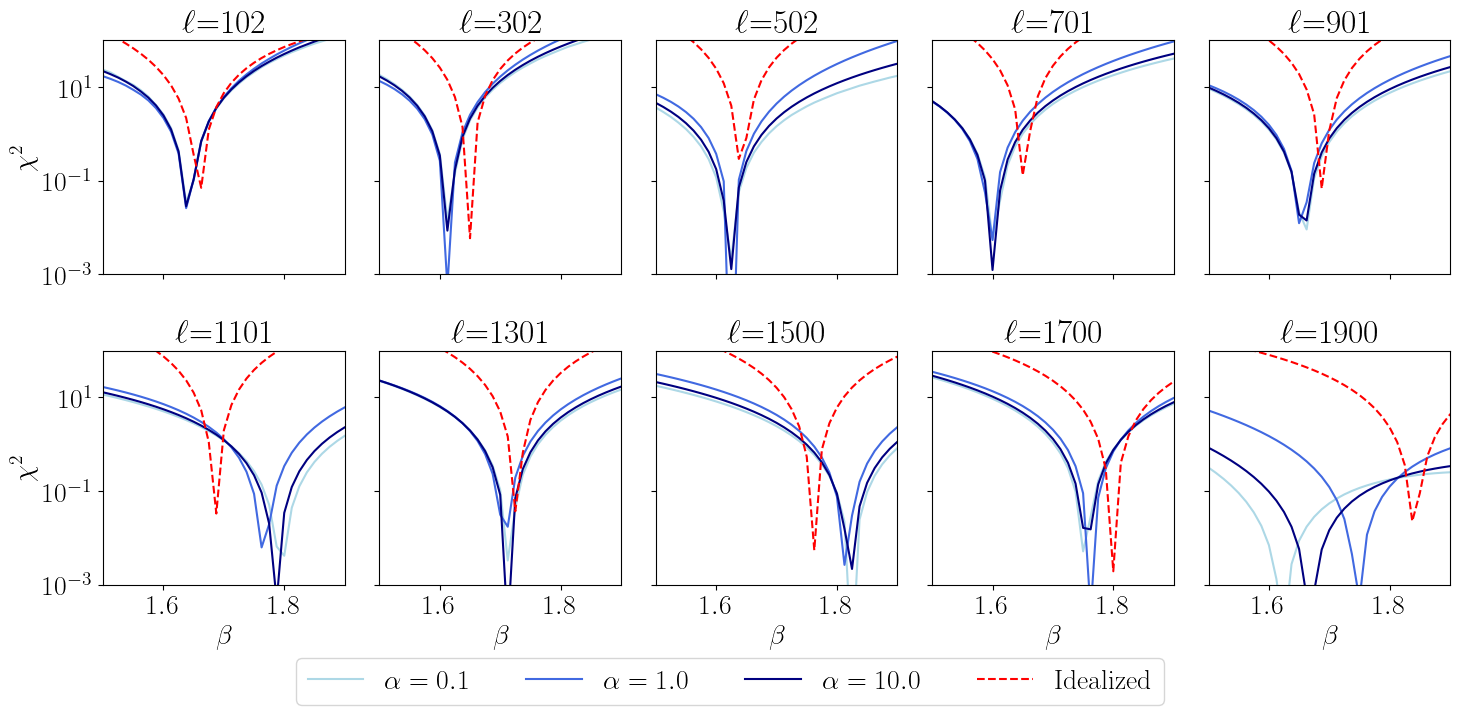

In [31]:
# Create a grid of 2 rows x 5 columns for 10 subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7), sharey=True, sharex=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

fmt = '-'
colors = ['lightblue', 'royalblue', 'navy']

for idx in range(10):
    ax = axes[idx]
    # Plot each set of data on the current subplot
    ax.plot(beta_arr, chi2_alpha0p1[idx], fmt, label=r'$\alpha=0.1$', color=colors[0])
    ax.plot(beta_arr, chi2_alpha1[idx], fmt, label=r'$\alpha=1.0$', color=colors[1])
    ax.plot(beta_arr, chi2_alpha10[idx], fmt, label=r'$\alpha=10.0$', color=colors[2])
    ax.plot(beta_arr, chi2_true[idx], label=r'Idealized', color='red', linestyle='dashed')
    
    # Configure plot appearance
    ax.set_yscale('log')
    if idx > 4:
        ax.set_xlabel(r'$\beta$')
    if idx == 0 or idx == 5:
        ax.set_ylabel(r'$\chi^2$')
    ax.set_xlim(1.5, 1.9)
    ax.set_title(r"$\ell$="+f'{int(np.round(mean_ells[idx]))}')
    plt.ylim(bottom=10**(-3), top=10**2)
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.05), fontsize=20)

# # Adjust layout to prevent overlapping
plt.tight_layout()

if save:
    plt.savefig(f'{save_dir}/chi2_vs_beta.pdf', bbox_inches='tight')

# Plot $\beta$ (with 1$\sigma$ error) in each bin

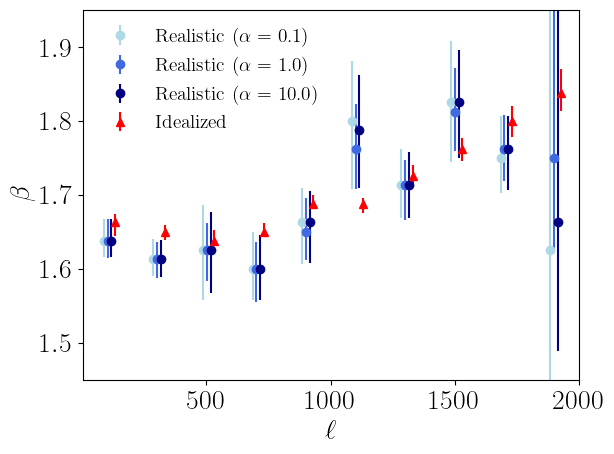

In [30]:
alpha = [0.1, 1.0, 10.0]
colors = ['lightblue', 'royalblue', 'navy']
for a, alpha_list in enumerate([beta_alpha0p1, beta_alpha1, beta_alpha10]):
    means_true, uppers_true, lowers_true, means_infl, uppers_infl, lowers_infl = alpha_list
    plt.errorbar(mean_ells+15*(a-1), means_infl, fmt='o', yerr=[lowers_infl, uppers_infl], label=r'Realistic ($\alpha=$'+f' {alpha[a]})', color=colors[a])
plt.errorbar(mean_ells+15*2, means_true, fmt='^', yerr=[lowers_true, uppers_true], label=f'Idealized', color='red')
plt.legend(loc='upper left', frameon=False, fontsize=14)
plt.xlabel(r'$\ell$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize=20)
plt.ylim(1.45,1.95)
plt.xlim(ellmin, ellmax)

if save:
    plt.savefig(f'{save_dir}/beta_vs_ell.pdf', bbox_inches='tight')


# Compare to $\beta$+$d\beta$

In [15]:
y_beta = hp.read_map(f"{base_dir1}/pyilc_outputs/final/needletILCmap_component_tSZ_deproject_CIB_realistic.fits")
y_beta_dbeta = hp.read_map(f"{base_dir1}/pyilc_outputs/final/needletILCmap_component_tSZ_deproject_CIB_CIB_dbeta.fits")
yopt = hp.read_map(f'{base_dir1}/pyilc_outputs/uninflated/needletILCmap_component_tSZ.fits')

ytrue = hp.read_map('/Users/kristen/Documents/GitHub/CIB-deproj/inputs/tsz_1024.fits')
h = hp.read_map('/Users/kristen/Documents/GitHub/CIB-deproj/inputs/halo_zsel_0.8_to_1.8_Msel_1e12_to_1e15_rot120.fits')



In [16]:
def binned(spectrum):
    '''
    ARGUMENTS
    ---------
    spectrum: 1D numpy array of length ellmax+1 containing some power spectrum

    RETURNS
    -------
    binned_spectrum: 1D numpy array of length Nbins containing binned power spectrum
    '''
    ells = np.arange(ellmax+1)
    Dl = ells*(ells+1)/2/np.pi*spectrum
    Nbins = int(np.round((ellmax-ellmin+1)/ells_per_bin))
    res = stats.binned_statistic(ells[ellmin:], Dl[ellmin:], statistic='mean', bins=Nbins)
    mean_ells = (res[1][:-1]+res[1][1:])/2
    binned_spectrum = res[0]/(mean_ells*(mean_ells+1)/2/np.pi)
    return binned_spectrum

In [17]:
def harmonic_space_cov(y1, h):
    '''
    ARGUMENTS
    ---------
    y1: 1D numpy array in RING format containing reconstructed y map
    h: 1D numpy array in RING format containing halo map

    RETURNS
    -------
    cov_hy: (Nbins, Nbins) ndarray containing Gaussian covariance matrix of halos and (y1-y2)
    ''' 
    hh = binned(hp.anafast(h, lmax=ellmax))
    hy = binned(hp.anafast(h, y1, lmax=ellmax))
    yy = binned(hp.anafast(y1, lmax=ellmax))
    Nmodes = (2*mean_ells+1)*ells_per_bin
    cov_hy = np.diag(1/Nmodes*(hy**2 + hh*yy))
    return cov_hy

In [18]:
hxy_beta = binned(hp.anafast(h, y_beta, lmax=ellmax))
hxy_beta_dbeta = binned(hp.anafast(h, y_beta_dbeta, lmax=ellmax))
y_beta_dbetaxy_beta_dbeta = binned(hp.anafast(y_beta_dbeta, lmax=ellmax))
y_betaxy_beta = binned(hp.anafast(y_beta, lmax=ellmax))
ytruexytrue = binned(hp.anafast(ytrue, lmax=ellmax))
y_betaxytrue = binned(hp.anafast(y_beta, ytrue, lmax=ellmax))
y_beta_dbetaxytrue = binned(hp.anafast(y_beta_dbeta, ytrue, lmax=ellmax))
yoptxyopt = binned(hp.anafast(yopt, lmax=ellmax))
yoptxytrue = binned(hp.anafast(yopt, ytrue, lmax=ellmax))
yoptxh = binned(hp.anafast(yopt, h, lmax=ellmax))
hxytrue = binned(hp.anafast(h, ytrue, lmax=ellmax))

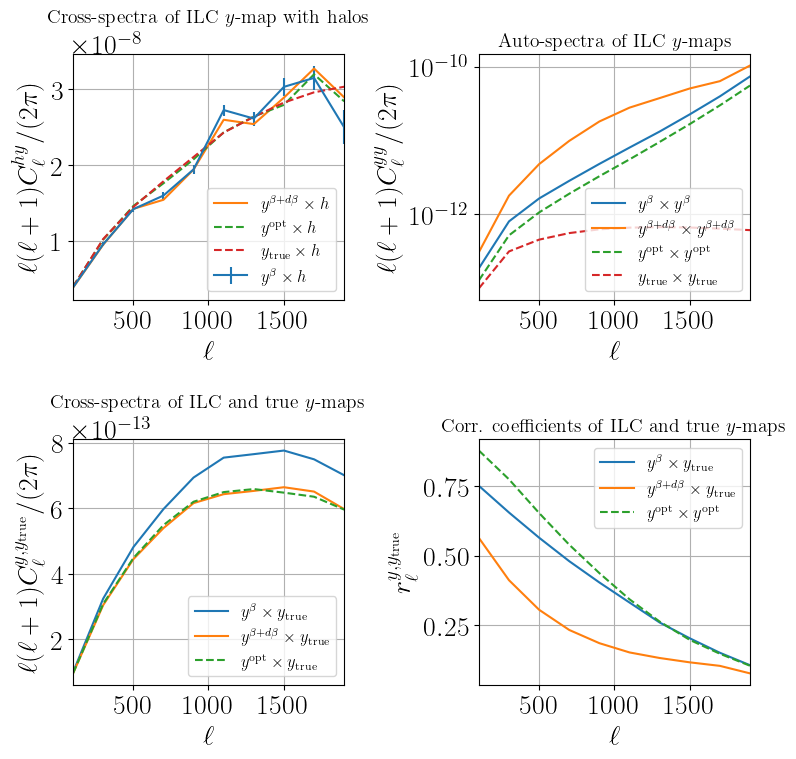

In [26]:
to_dl = mean_ells*(mean_ells+1)/2/np.pi
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs = axs.flatten()
for n, ax in enumerate(axs):
    plt.axes(ax)
    if n==0:
        hxy_beta_cov = harmonic_space_cov(y_beta, h)
        plt.errorbar(mean_ells, to_dl*hxy_beta, yerr=to_dl*np.sqrt(np.diag(hxy_beta_cov)), label=r'$y^{\beta} \times h$')
        plt.plot(mean_ells, to_dl*hxy_beta_dbeta, label=r'$y^{\beta + d\beta} \times h$')
        plt.plot(mean_ells, to_dl*yoptxh, label=r'$y^{\rm opt} \times h$', linestyle='dashed')
        plt.plot(mean_ells, to_dl*hxytrue, label=r'$y_{\rm true} \times h$', linestyle='dashed')
        plt.legend(fontsize=12)
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\ell(\ell+1)C_\ell^{hy}/(2\pi)$')
        plt.grid()
        plt.xlim(mean_ells[0], mean_ells[-1])
        plt.title(r'Cross-spectra of ILC $y$-map with halos', fontsize=14)
    elif n==1:
        plt.plot(mean_ells, to_dl*y_betaxy_beta, label=r'$y^{\beta} \times y^{\beta}$')
        plt.plot(mean_ells, to_dl*y_beta_dbetaxy_beta_dbeta, label=r'$y^{\beta + d\beta} \times y^{\beta + d\beta}$')
        plt.plot(mean_ells, to_dl*yoptxyopt, label=r'$y^{\rm opt} \times y^{\rm opt}$', linestyle='dashed')
        plt.plot(mean_ells, to_dl*ytruexytrue, label=r'$y_{\rm true} \times y_{\rm true}$', linestyle='dashed')
        plt.legend(fontsize=12)
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\ell(\ell+1)C_\ell^{yy}/(2\pi)$')
        plt.grid()
        plt.xlim(mean_ells[0], mean_ells[-1])
        plt.yscale('log')
        plt.title(r'Auto-spectra of ILC $y$-maps', fontsize=14)      
    elif n==2:
        plt.plot(mean_ells, to_dl*y_betaxytrue, label=r'$y^{\beta} \times y_{\mathrm{true}}$')
        plt.plot(mean_ells, to_dl*y_beta_dbetaxytrue, label=r'$y^{\beta+d\beta} \times y_{\mathrm{true}}$')
        plt.plot(mean_ells, to_dl*yoptxytrue, label=r'$y^{\rm opt} \times y_{\mathrm{true}}$', linestyle='dashed')
        plt.legend(fontsize=12)
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\ell(\ell+1)C_\ell^{y,y_{\mathrm{true}}}/(2\pi)$')
        plt.grid(which='both')
        plt.xlim(mean_ells[0], mean_ells[-1])
        plt.title('Cross-spectra of ILC and true $y$-maps', fontsize=14)
    elif n==3:
        plt.plot(mean_ells,y_betaxytrue/np.sqrt(ytruexytrue*y_betaxy_beta), label=r'$y^{\beta} \times y_{\mathrm{true}}$')
        plt.plot(mean_ells,y_beta_dbetaxytrue/np.sqrt(ytruexytrue*y_beta_dbetaxy_beta_dbeta), label=r'$y^{\beta+d\beta} \times y_{\mathrm{true}}$')
        plt.plot(mean_ells,yoptxytrue/np.sqrt(ytruexytrue*yoptxyopt), label=r'$y^{\rm opt} \times y^{\rm opt}$', linestyle='dashed')
        plt.legend(fontsize=12)
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$r_\ell^{y,y_{\mathrm{true}}}$')
        plt.grid()
        plt.xlim(mean_ells[0], mean_ells[-1])
        plt.title('Corr. coefficients of ILC and true $y$-maps', fontsize=14)
plt.tight_layout()

if save:
    plt.savefig(f'{save_dir}/dbeta_comparison.pdf', bbox_inches='tight')

# Stacking

<Figure size 640x480 with 0 Axes>

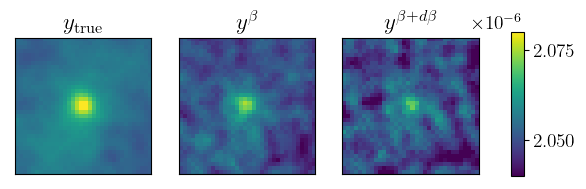

In [39]:
stacked_patch_2d_ytrue = pickle.load(open('stacks/stack_ytrue.p', 'rb'))
stacked_patch_2d_beta = pickle.load(open('stacks/stack_y_beta.p', 'rb'))
stacked_patch_2d_beta_dbeta = pickle.load(open('stacks/stack_y_beta_dbeta.p', 'rb'))


plt.clf()


plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size'   : 14})
plt.rc_context({'axes.autolimit_mode': 'round_numbers'})

fig, axs = plt.subplots(1,3)
vmin = 2.04e-6
vmax = 2.08e-6

for a, ax in enumerate(axs):
    plt.axes(ax)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    if a == 0:
        im0 = plt.imshow(stacked_patch_2d_ytrue, vmin=vmin, vmax=vmax)
        plt.title(r'$y_{\rm true}$')
    elif a == 1:
        im1 = plt.imshow(stacked_patch_2d_beta, vmin=vmin, vmax=vmax)
        plt.title(r'$y^{\beta}$')
    else:
        im2 = plt.imshow(stacked_patch_2d_beta_dbeta, vmin=vmin, vmax=vmax)
        plt.title(r'$y^{\beta+d\beta}$')
        
# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.90, 0.35, 0.02, 0.3])
fig.colorbar(im2, cax=cbar_ax)


if save:
    plt.savefig(f'{save_dir}/stacking.pdf', bbox_inches='tight')

plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size'   : 20})
plt.rc_context({'axes.autolimit_mode': 'round_numbers'})
